In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('wowah_data.csv')

In [3]:
## 전처리

In [4]:
# 컬럼명에 있는 공백 제거
for col in df.columns:
    df = df.rename(columns={col:col.strip()})

In [5]:
# timestamp 컬럼 datetime 유형으로 변경
df['time'] = pd.to_datetime(df['timestamp'])

In [6]:
df = df.rename(columns={'time':'datetime'})

In [7]:
df['year'] = df['datetime'].dt.year  
df['month'] = df['datetime'].dt.month  

In [8]:
df['date'] = df['datetime'].dt.date  
df['time'] = df['datetime'].dt.time  

In [9]:
# 이탈 요인 분석

In [10]:
df = df.sort_values(by=['char', 'datetime']).reset_index()

In [11]:
first_log = df.groupby('char').first()

In [12]:
last_log = df.groupby('char').last()

In [13]:
first_log = first_log[['level', 'race', 'charclass', 'zone', 'guild', 'datetime']].reset_index()
last_log = last_log[['level', 'race', 'charclass', 'zone', 'guild', 'datetime']].reset_index()

In [14]:
first_log = first_log.rename(columns={'datetime':'first_log_time'})
last_log = last_log.rename(columns={'datetime':'last_log_time'})

In [15]:
user_time = pd.merge(first_log, last_log[['char', 'last_log_time']], on='char')

In [16]:
# 90일 이상 접속하지 않은 유저를 이탈한 유저로 규정
last_log['churn'] = pd.to_datetime('2008-12-31') - last_log.last_log_time > timedelta(days=90)

In [17]:
last_log['churn'] = last_log['churn'].astype('int')

In [18]:
churn_users = last_log[last_log.churn==1].reset_index()

In [19]:
#overall 이탈률
last_log.churn.mean() # 45%의 이탈률

0.45076832467741074

In [20]:
#유입시기별 이탈률
user_time['month'] = user_time['first_log_time'].dt.strftime('%Y-%m')

In [21]:
user_time['date'] = user_time['first_log_time'].dt.date

In [22]:
user_time['churn'] = pd.to_datetime('2008-12-31') - user_time.last_log_time > timedelta(days=90)

<AxesSubplot:xlabel='month', ylabel='churn'>

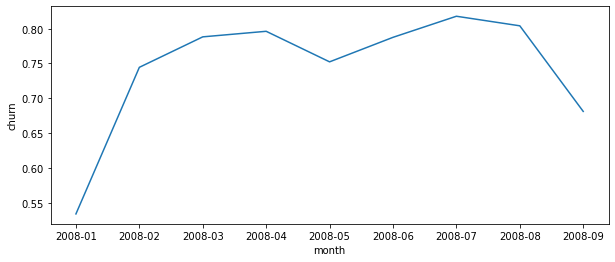

In [23]:
churn_rate_monthly = user_time.groupby('month').churn.mean().reset_index()[:9]
plt.figure(figsize = (10,4))
sns.lineplot(x='month', y='churn', data=churn_rate_monthly, sort=0)

<AxesSubplot:xlabel='date', ylabel='churn'>

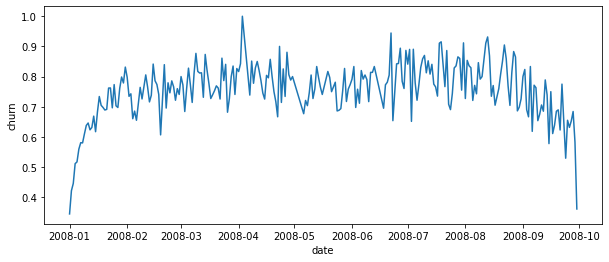

In [24]:
user_time_re = user_time[user_time.month < '2008-10']
churn_rate_daily = user_time_re.groupby('date').churn.mean().reset_index()
plt.figure(figsize = (10,4))
sns.lineplot(x='date', y='churn', data=churn_rate_daily, sort=0)

* 2008년 1월에 이탈률이 크게 증가함. 다르게 말하면 2008년 1월 초에 진입한 유저들은 게임을 계속하고 있음. 원인 파악 필요.

<AxesSubplot:xlabel='level', ylabel='char'>

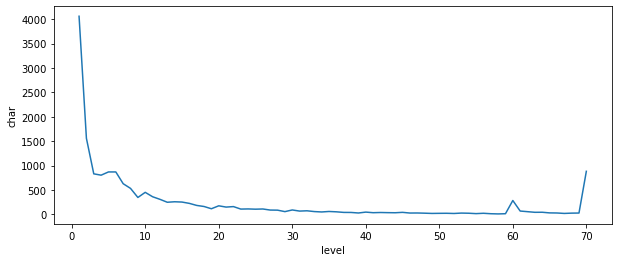

In [25]:
#레벨별 이탈율
churn_level = churn_users.groupby('level').char.count().reset_index()

plt.figure(figsize = (10,4))
sns.lineplot(x='level', y='char', data=churn_level, sort=0)

* 레벨 10 이하에서 많이 떠나므로 레벨 10까지 도달하게 만드는 것이 중요
* 레벨 60에서도 다소 떠난 유저가 많아 게임을 지속할 새로운 요인을 제공할 필요가 있음.
* 최고 레벨인 70 이후에 떠나는 유저들은 더이상 할 것이 없어서 떠나는 것으로 보임.

<AxesSubplot:xlabel='char', ylabel='zone'>

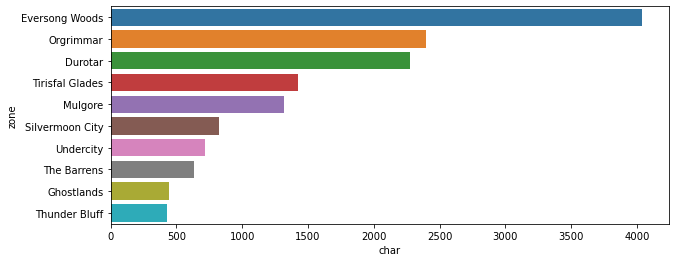

In [26]:
churn_zone = churn_users.groupby('zone').char.count().reset_index()
churn_zone_top10 = churn_zone.sort_values(by='char', ascending=False)[:10]

plt.figure(figsize = (10,4))
sns.barplot(x='char', y='zone', data=churn_zone_top10)

In [27]:
nusers_race_class = last_log.groupby(by=['race', 'charclass']).char.count().reset_index().rename(columns={'char':'total_users'})

In [28]:
cusers_race_class = churn_users.groupby(by=['race', 'charclass']).char.count().reset_index().rename(columns={'char':'churn_users'})

* 많이 이탈하는 zone에서 유저들이 어떤 장애물 때문에 떠나는 지 확인 필요

In [29]:
race_n_class = pd.merge(nusers_race_class, cusers_race_class, on=['race', 'charclass'])
race_n_class['churn_rate'] = race_n_class['churn_users'] / race_n_class['total_users']

In [30]:
race_n_class = race_n_class.sort_values(by='churn_rate', ascending=False)

In [31]:
race_n_class['race-class'] = race_n_class['race'] + '-' + race_n_class['charclass']

<AxesSubplot:xlabel='churn_rate', ylabel='race-class'>

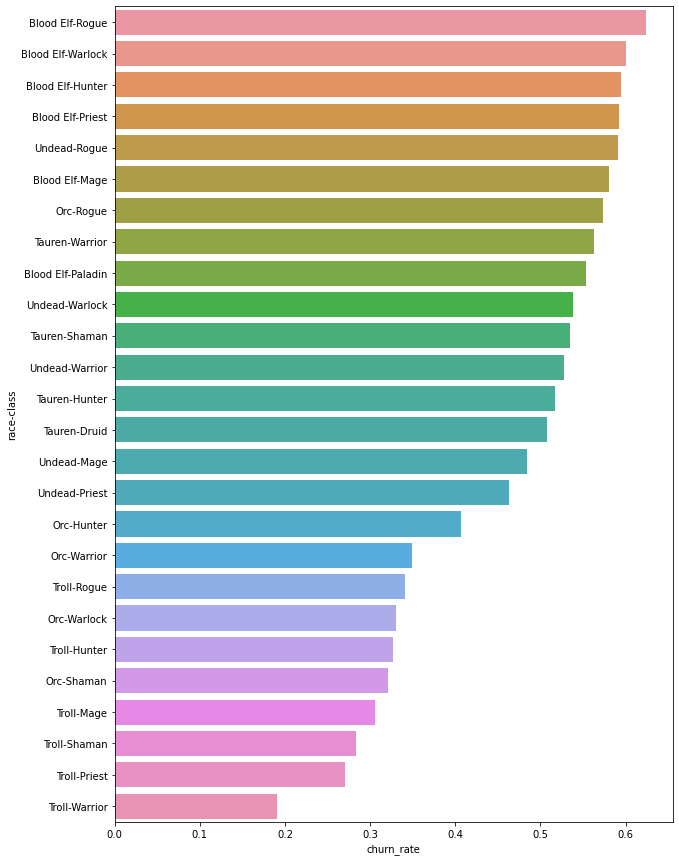

In [32]:
plt.figure(figsize = (10,15))
sns.barplot(x='churn_rate', y='race-class', data=race_n_class)

* 대체로 bloodelf의 이탈률이 높아서 원인 파악 필요
* 초심자에게는 troll-warrior 조합을 추천

In [ ]:
* 어둠땅부턴 종족이나 직업 퀘스트/추방자의 해안으로 10레벨까지 / 격전의 아제로스 지역에서 50레벨까지 / 어둠땅 지역에서 60레벨까지

In [33]:
zones = pd.read_csv('zones.csv')
locations = pd.read_csv('locations.csv')

In [34]:
# 지역별 최소 레벨
zone_level_min = zones[['Zone_Name', 'Min_req_level']].rename(columns={'Zone_Name':'zone'})

In [37]:
zone_churn_level = pd.merge(churn_zone, zone_level_min, on='zone')

<AxesSubplot:xlabel='Min_req_level', ylabel='char'>

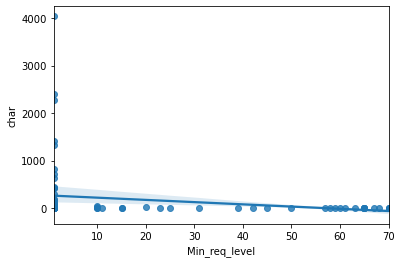

In [38]:
sns.regplot(x='Min_req_level', y='char', data=zone_churn_level)

In [39]:
# 유저의 이탈이 가장 빈번하게 발생하는 지역
zone_churn_level.sort_values(by='char', ascending=False)[:20]

,zone,char,Min_req_level
25,Eversong Woods,4037,1
46,Orgrimmar,2394,1
20,Durotar,2277,1
77,Tirisfal Glades,1423,1
42,Mulgore,1319,1
57,Silvermoon City,825,1
79,Undercity,717,1
65,The Barrens,635,1
30,Ghostlands,447,1
76,Thunder Bluff,431,1


* eversongwoods: 영원노래의 숲: 블러드 엘프 캐릭터로 플레이할 경우 여기에서 게임을 시작. 퀘스트 동선이 산들바람 마을을 중심으로 서부 성소, 원정순찰대 산장, 숲 남부 등 여기저기 돌아다니도록 짜여 있기 때문에 매우 피곤. 블러드 엘프 종족으로 시작하는 경우 이탈이 심한 이유가 이것 아닌지.
* 오그리마 : 정문에 서있던 사울팽,[2] 굴곡이 심한 지형, 구불구불한 길, 곳곳에 산재한 뒷골목 등 구조가 매우 복잡하다. 특히 수장인 스랄까지의 접근성이 최악
* 듀로타 : 눈 아프다. 필드 전체가 밝으면서 새빨갛기 때문에 불모의 땅의 황색에 눈이 익숙해져 있는 상태에서 진입하면 부담

In [40]:
zone_churn_level_high = zone_churn_level[zone_churn_level.Min_req_level>50]
zone_churn_level_high.sort_values(by='char', ascending=False)[:20]

,zone,char,Min_req_level
34,Hellfire Ramparts,8,57
37,Karazhan,8,68
39,Magisters' Terrace,6,65
70,The Mechanar,4,65
40,Mana-Tombs,3,61
63,Tempest Keep,3,70
71,The Shattered Halls,2,65
72,The Steamvault,2,65
74,The Underbog,2,60
7,Black Temple,1,70


In [73]:
df_zone = pd.merge(df, zone_level_min, how='left', on='zone')

In [74]:
df_zone_user = df_zone.groupby('char').agg({'level':'max', 'Min_req_level':'max'}) #유저별 최종 레벨과 도달한 지역 중 가장 높은 레벨을 요구한 경우

In [75]:
df_zone_user['level10'] = df_zone_user.Min_req_level.map(lambda x: '1-10' if x <= 10 else None)
df_zone_user['level20'] = df_zone_user.Min_req_level.map(lambda x: '10-20' if x <= 20 and x > 10 else None)
df_zone_user['level30'] = df_zone_user.Min_req_level.map(lambda x: '20-30' if x <= 30 and x > 20 else None)
df_zone_user['level40'] = df_zone_user.Min_req_level.map(lambda x: '30-40' if x <= 40 and x > 30 else None)
df_zone_user['level50'] = df_zone_user.Min_req_level.map(lambda x: '40-50' if x <= 50 and x > 40 else None)
df_zone_user['level60'] = df_zone_user.Min_req_level.map(lambda x: '50-60' if x <= 60 and x > 50 else None)
df_zone_user['level70'] = df_zone_user.Min_req_level.map(lambda x: '60-70' if x <= 70 and x > 60 else None)
df_zone_user['level80'] = df_zone_user.Min_req_level.map(lambda x: '70-80' if x <= 80 and x > 70 else None)

In [76]:
df_zone_user_re = df_zone_user.fillna('')

In [77]:
df_zone_user_re['level_range'] = df_zone_user_re['level10'] + df_zone_user_re['level20'] + df_zone_user_re['level30'] + df_zone_user_re['level40'] \
                                + df_zone_user_re['level50'] + df_zone_user_re['level60'] + df_zone_user_re['level70'] + df_zone_user_re['level80']

In [78]:
df_zone_user_re = df_zone_user_re[['level', 'Min_req_level', 'level_range']]

In [79]:
level_funnel_df = df_zone_user_re.groupby('level_range').count().reset_index()[['level_range', 'Min_req_level']].rename(columns={'Min_req_level':'users'})

In [80]:
level_funnel_df = level_funnel_df.sort_values(by='level_range', ascending=False)

In [81]:
level_funnel_df['cumsum_users'] = level_funnel_df.users.cumsum()

In [82]:
level_funnel_df = level_funnel_df.sort_values(by='level_range', ascending=True)

In [87]:
#전체 유저 대비 단계별 전환율 계산
level_funnel_df.cumsum_users / level_funnel_df.cumsum_users[0]

0    1.000000
1    0.185040
2    0.167104
3    0.147267
4    0.131338
5    0.122584
6    0.107137
7    0.026530
Name: cumsum_users, dtype: float64

In [88]:
#이전 단계별 전환율 계산
for i in range(len(level_funnel_df)-1):
    level_funnel_df.loc[i+1, 'conversion'] = level_funnel_df.loc[i+1, 'cumsum_users'] / level_funnel_df.loc[i, 'cumsum_users']

In [89]:
level_funnel_df

,level_range,users,cumsum_users,conversion
0,1-10,30442,37354,NaN
1,10-20,670,6912,0.185040
2,20-30,741,6242,0.903067
3,30-40,595,5501,0.881288
4,40-50,327,4906,0.891838
5,50-60,577,4579,0.933347
6,60-70,3011,4002,0.873990
7,70-80,991,991,0.247626


* 리치왕의분노(리분) 런칭 후 퍼널 전환율 분석

In [90]:
df_lk = df_zone[df_zone.datetime >= '2008-11-13'].reset_index()

In [91]:
df_zone_user_lk = df_lk.groupby('char').agg({'level':'max', 'Min_req_level':'max'}) #유저별 최종 레벨과 도달한 지역 중 가장 높은 레벨을 요구한 경우

df_zone_user_lk['level10'] = df_zone_user_lk.Min_req_level.map(lambda x: '1-10' if x <= 10 else None)
df_zone_user_lk['level20'] = df_zone_user_lk.Min_req_level.map(lambda x: '10-20' if x <= 20 and x > 10 else None)
df_zone_user_lk['level30'] = df_zone_user_lk.Min_req_level.map(lambda x: '20-30' if x <= 30 and x > 20 else None)
df_zone_user_lk['level40'] = df_zone_user_lk.Min_req_level.map(lambda x: '30-40' if x <= 40 and x > 30 else None)
df_zone_user_lk['level50'] = df_zone_user_lk.Min_req_level.map(lambda x: '40-50' if x <= 50 and x > 40 else None)
df_zone_user_lk['level60'] = df_zone_user_lk.Min_req_level.map(lambda x: '50-60' if x <= 60 and x > 50 else None)
df_zone_user_lk['level70'] = df_zone_user_lk.Min_req_level.map(lambda x: '60-70' if x <= 70 and x > 60 else None)
df_zone_user_lk['level80'] = df_zone_user_lk.Min_req_level.map(lambda x: '70-80' if x <= 80 and x > 70 else None)

df_zone_user_lk_re = df_zone_user_lk.fillna('')

df_zone_user_lk_re['level_range'] = df_zone_user_lk_re['level10'] + df_zone_user_lk_re['level20'] + df_zone_user_lk_re['level30'] + df_zone_user_lk_re['level40'] \
                                + df_zone_user_lk_re['level50'] + df_zone_user_lk_re['level60'] + df_zone_user_lk_re['level70'] + df_zone_user_lk_re['level80']

In [92]:
df_zone_user_lk_re = df_zone_user_lk_re[['level', 'Min_req_level', 'level_range']]

In [93]:
funnel_df_lk = df_zone_user_lk_re.groupby('level_range').count().reset_index()[['level_range', 'Min_req_level']].rename(columns={'Min_req_level':'users'})
funnel_df_lk = funnel_df_lk.sort_values(by='level_range', ascending=False)
funnel_df_lk['cumsum_users'] = funnel_df_lk.users.cumsum()
funnel_df_lk = funnel_df_lk.sort_values(by='level_range', ascending=True)

In [94]:
#전체 유저 대비 단계별 전환율 계산
funnel_lk = pd.DataFrame(funnel_df_lk.cumsum_users / funnel_df_lk.cumsum_users[0]).reset_index()
level_funnel

,index,cumsum_users
0,0,1.000000
1,1,0.235726
2,2,0.221407
3,3,0.207962
4,4,0.191549
5,5,0.182906
6,6,0.161254
7,7,0.086520


In [95]:
#이전 단계별 전환율 계산
for i in range(len(funnel_df_lk)-1):
    funnel_df_lk.loc[i+1, 'conversion'] = funnel_df_lk.loc[i+1, 'cumsum_users'] / funnel_df_lk.loc[i, 'cumsum_users']

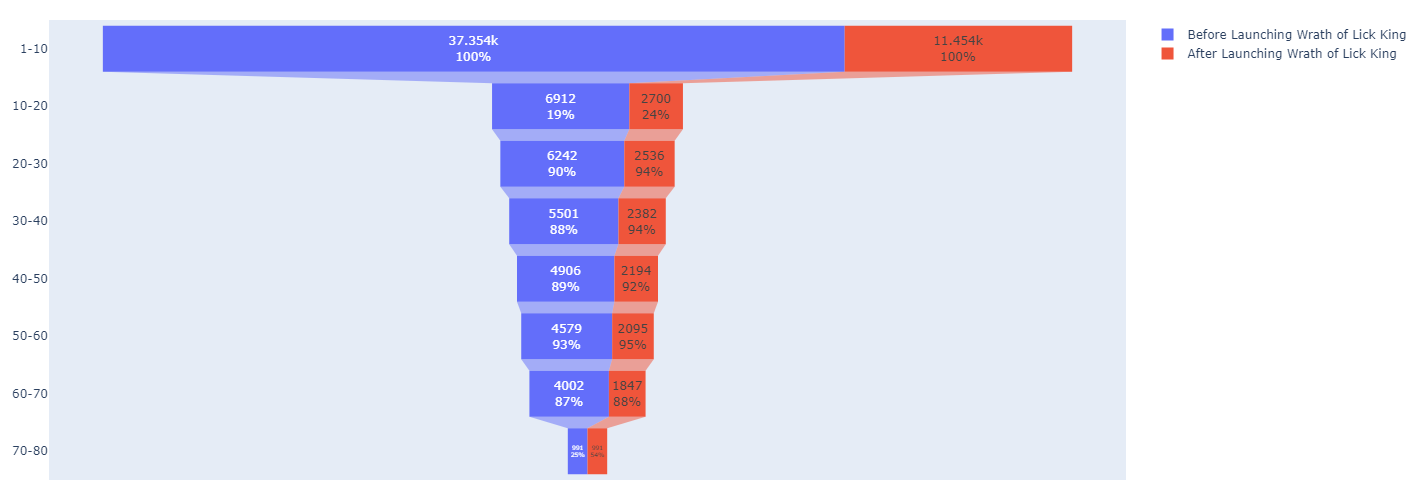

In [107]:
from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Before Launching Wrath of Lick King',
    y = level_funnel_df['level_range'],
    x = level_funnel_df['cumsum_users'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'After Launching Wrath of Lick King',
    y = funnel_df_lk['level_range'],
    x = funnel_df_lk['cumsum_users'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    width=1200,
    height=500
)


fig.show()

* 리분 런칭 이후 모든 단계의 전환율이 상승했으며, 새로 개설된 70-80 레벨 구간까지 진입한 유저도 이전 단계 대비 50퍼센트 이상으로 확인됨.